In [ ]:

!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.28.0 datasets==2.16.1
!pip install scikit-learn==1.2.2 seaborn==0.12.2 accelerate==0.24.1
!pip install numpy==1.25.2 pandas==2.0.3
!pip install evaluate



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [ ]:
from google.colab import drive

In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


# violation result

In [ ]:
import os
import time
import json
import warnings
import logging
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

warnings.filterwarnings('ignore')

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('Violationresult')

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerClassifier:
    def __init__(self, model_name="JQ1984/legalbert_gdpr_pretrained", num_labels=None, output_dir="./results", multi_label=False):
        self.model_name = model_name
        self.num_labels = num_labels
        self.output_dir = output_dir
        self.multi_label = multi_label
        self.tokenizer = None
        self.model = None
        self.trainer = None
        self.train_time = None # User's original attribute

        # Attributes from user's original prepare_data/load_external_test_data
        self.label_encoder = None
        self.kf = None # KFold object
        self.fold_datasets = [] # List of (train_dataset, val_dataset) tuples for K-Fold

        # Attributes needed for external test data handling by original methods and baseline
        self.X_test_external_original = None # List of text strings for external test set
        self.y_test_external = None # Numpy array of labels for external test set
        self.external_test_dataset = None # Hugging Face Dataset for external test set

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # For baseline model outputs (minimal addition for baseline methods to function)
        self.baseline_output_dir = os.path.join(self.output_dir, "baseline_model_results")
        if not os.path.exists(self.baseline_output_dir):
            os.makedirs(self.baseline_output_dir)
        self.baseline_model_last_fold = None # Stores the pipeline from the last fold of baseline CV


    def _features_to_text(self, df): # User's original method
        texts = []
        for _, row in df.iterrows():
            text = ""
            for col, val in row.items():
                if col == 'gdpr_clause' and isinstance(val, str):
                    clauses = [clause.strip() for clause in str(val).split(',')]
                    clause_text = " and ".join(clauses)
                    text += f"GDPR clauses are {clause_text}. "
                elif col == 'Date' and isinstance(val, str):
                    text += f"Date is {val}. "
                elif col in ['country', 'company_industry'] and isinstance(val, str):
                    text += f"{col} is {val}. "
                elif isinstance(val, (int, float)):
                    if val == 1:
                        feature_name = col.replace('_', ' ').lower()
                        text += f"{feature_name} is true. "
                elif isinstance(val, str):
                    text += f"{col} is {val}. "
            texts.append(text)
        return texts

    def prepare_data(self, df, target_columns, n_splits=5): # User's original method
        """Prepare data for K-fold cross validation"""
        logger.info(f"Preparing dataset for {n_splits}-fold cross validation, target columns: {target_columns}")

        exclude_columns = ['fine_amount']
        exclude_columns.extend([col for col in df.columns if col.startswith('violation_nature_')])

        if 'gdpr_clause' in df.columns:
            exclude_columns.append('gdpr_clause')

        df_copy = df.drop(columns=exclude_columns, errors='ignore') # Use df_copy to avoid modifying original df for other potential uses
        logger.info(f"Excluded columns: {exclude_columns}")

        if not target_columns:
            raise ValueError("Target columns not specified. Ensure the dataset contains a 'violation_result' column or provide a custom list of target columns.")

        missing_cols = [col for col in target_columns if col not in df_copy.columns]
        if missing_cols:
            raise ValueError(f"The following target columns are missing from the dataset after exclusions: {missing_cols}")

        for col in df_copy.select_dtypes(include=['object']).columns:
            df_copy[col] = df_copy[col].fillna('')
        for col in df_copy.select_dtypes(include=['number']).columns:
            if col not in target_columns:
                df_copy[col] = df_copy[col].fillna(df_copy[col].median())

        target_col = target_columns[0]

        if df_copy[target_col].dtype == 'object':
            logger.info(f"Target column '{target_col}' is categorical, converting to numeric categories")
            le = LabelEncoder()
            df_copy[target_col] = le.fit_transform(df_copy[target_col])
            self.label_encoder = le
            logger.info(f"Category mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

        X = df_copy.drop(columns=target_columns)
        Y = df_copy[target_col].astype('int64')

        # Set self.num_labels if not already set or if it mismatches
        if self.num_labels is None or self.num_labels != len(Y.unique()):
            if self.num_labels is not None and self.num_labels != len(Y.unique()):
                 logger.warning(f"Initialized num_labels ({self.num_labels}) does not match unique values in target ({len(Y.unique())}). Updating.")
            self.num_labels = len(Y.unique())


        logger.info(f"Feature count (after exclusions for text generation): {X.shape[1]}, Sample count: {X.shape[0]}")
        logger.info(f"Category count: {self.num_labels}, Category distribution: {Y.value_counts().to_dict()}")

        X_text = self._features_to_text(X)

        self.kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        self.fold_datasets = []

        for train_idx, val_idx in self.kf.split(X_text):
            X_train_fold_text = [X_text[i] for i in train_idx]
            X_val_fold_text = [X_text[i] for i in val_idx]
            y_train_fold = Y.iloc[train_idx].values
            y_val_fold = Y.iloc[val_idx].values

            train_dataset = Dataset.from_dict({'text': X_train_fold_text, 'labels': y_train_fold})
            val_dataset = Dataset.from_dict({'text': X_val_fold_text, 'labels': y_val_fold})
            self.fold_datasets.append((train_dataset, val_dataset))

        logger.info(f"Created {n_splits} folds for cross-validation stored in self.fold_datasets")
        return True


    def load_external_test_data(self, file_path, target_columns): # User's original method
        """Load external test dataset"""
        logger.info(f"Loading external test data from {file_path}")

        if file_path.endswith('.csv'):
            test_df = pd.read_csv(file_path, sep=';')
        else:
            raise ValueError("Unsupported file format")

        if 'Affected_data_volume' in test_df.columns:
            logger.info("Handling Affected_data_volume column")
            if test_df['Affected_data_volume'].dtype == 'object':
                test_df['Affected_data_volume'] = pd.to_numeric(
                    test_df['Affected_data_volume'].replace('unspecific', 0),
                    errors='coerce'
                ).fillna(0)

        for col in test_df.select_dtypes(include=['object']).columns:
            test_df[col] = test_df[col].fillna('')
        for col in test_df.select_dtypes(include=['number']).columns:
            if col not in target_columns:
                test_df[col] = test_df[col].fillna(test_df[col].median())

        target_col = target_columns[0]
        has_labels_in_file = False
        if target_col in test_df.columns:
            has_labels_in_file = True
            if hasattr(self, 'label_encoder') and self.label_encoder and test_df[target_col].dtype == 'object':
                # Fill NaNs before checking unique or transforming
                test_df[target_col] = test_df[target_col].fillna(self.label_encoder.classes_[0])
                unknown_categories = set(test_df[target_col].unique()) - set(self.label_encoder.classes_)
                if unknown_categories:
                    logger.warning(f"Unknown categories found in the test set: {unknown_categories}")
                    mode_category = self.label_encoder.classes_[0]
                    for cat in unknown_categories:
                        test_df.loc[test_df[target_col] == cat, target_col] = mode_category
                test_df[target_col] = self.label_encoder.transform(test_df[target_col])

            self.y_test_external = test_df[target_col].astype('int64').values
        else:
            self.y_test_external = None

        X_test_df = test_df.drop(columns=[target_col] if target_col in test_df.columns else [], errors='ignore')
        self.X_test_external_original = self._features_to_text(X_test_df)

        if has_labels_in_file and self.y_test_external is not None:
            self.external_test_dataset = Dataset.from_dict(
                {'text': self.X_test_external_original, 'labels': self.y_test_external}
            )
        else:
            self.external_test_dataset = Dataset.from_dict({'text': self.X_test_external_original})

        logger.info(f"External test size: {len(self.external_test_dataset)}")
        return True

    def load_model(self): # User's original method
        logger.info(f"Loading model: {self.model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.num_labels is None: # Ensure num_labels is set
            raise ValueError("self.num_labels has not been set. Run prepare_data first.")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels,
            problem_type="multi_label_classification" if self.multi_label else None
        )
        self.model.to(device)

    def tokenize_data(self, dataset, max_length=256): # User's original method
        """Tokenize a single dataset"""
        if not self.tokenizer: # Added check
            logger.error("Tokenizer not available. Load model first.")
            return None
        def tokenize_function(examples):
            return self.tokenizer(
                examples['text'],
                padding="max_length",
                truncation=True,
                max_length=max_length
            )
        return dataset.map(tokenize_function, batched=True)

    def train_and_evaluate_kfold(self, epochs=3, batch_size=16, learning_rate=3e-5, weight_decay=0.01): # User's original method
        """Train and evaluate using K-fold cross validation, but avoid multiple model loads"""
        logger.info("Starting K-fold cross validation training")

        self.load_model() # Load model only once (sets self.model and self.tokenizer)

        fold_results = []
        fold_accuracies = []
        all_fold_train_times = []

        for fold, (train_dataset, val_dataset) in enumerate(self.fold_datasets):
            logger.info(f"Training fold {fold+1}/{len(self.fold_datasets)}")

            fold_output_dir = os.path.join(self.output_dir, f"fold_{fold+1}")
            if not os.path.exists(fold_output_dir):
                os.makedirs(fold_output_dir)

            tokenized_train = self.tokenize_data(train_dataset)
            tokenized_val = self.tokenize_data(val_dataset)

            if tokenized_train is None or tokenized_val is None:
                logger.error(f"Tokenization failed for fold {fold+1}. Skipping.")
                fold_accuracies.append(0.0)
                fold_results.append({
                    'fold': fold+1,
                    'eval_results': {'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0},
                    'training_time': 0.0
                })
                continue

            if fold > 0:
                logger.info(f"Reinitializing model weights for fold {fold+1} using local files.")
                self.model = AutoModelForSequenceClassification.from_pretrained(
                    self.model_name,
                    num_labels=self.num_labels,
                    problem_type="multi_label_classification" if self.multi_label else None,
                    from_tf=False,
                    local_files_only=True
                )
                self.model.to(device)

            training_args = TrainingArguments(
                output_dir=fold_output_dir,
                num_train_epochs=epochs,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                weight_decay=weight_decay,
                learning_rate=learning_rate,
                logging_dir=f"{fold_output_dir}/logs",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                greater_is_better=True,
                push_to_hub=False,
                report_to="none"
            )

            def compute_metrics(eval_pred): # User's original compute_metrics
                logits, labels = eval_pred
                if np.isnan(labels).any() or np.isinf(labels).any():
                    print("Warning: Labels contain NaN or Inf values")
                    labels = np.nan_to_num(labels, nan=0.0, posinf=1.0, neginf=0.0)
                preds = np.argmax(logits, axis=1)
                print(f"Labels shape: {labels.shape}, Predictions shape: {preds.shape}")
                print(f"Labels type: {type(labels)}, Predictions type: {type(preds)}")
                print(f"Unique labels: {np.unique(labels)}")
                print(f"Unique predictions: {np.unique(preds)}")
                try:
                    precision, recall, f1, _ = precision_recall_fscore_support(
                        labels, preds, average='macro', zero_division=0
                    )
                    acc = (preds == labels).mean()
                    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}
                except Exception as e:
                    print(f"Error calculating metrics: {e}")
                    return {'accuracy': 0.0, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}

            current_trainer = Trainer( # Renamed to avoid confusion with self.trainer
                model=self.model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                compute_metrics=compute_metrics,
                tokenizer=self.tokenizer
            )

            start_time_fold = time.time()
            current_trainer.train()
            # self.train_time = time.time() - start_time_fold # User's original used self.train_time
            # For clarity, using a local variable for fold-specific time and then for avg
            current_fold_train_time = time.time() - start_time_fold
            all_fold_train_times.append(current_fold_train_time)


            eval_results = current_trainer.evaluate()
            fold_accuracy = eval_results['eval_accuracy']
            fold_accuracies.append(fold_accuracy)
            logger.info(f"Fold {fold+1} training time: {current_fold_train_time:.2f}s, Accuracy: {fold_accuracy:.4f}")

            with open(os.path.join(fold_output_dir, 'eval_results.json'), 'w') as f:
                json.dump(eval_results, f)
            fold_results.append({
                'fold': fold+1,
                'eval_results': eval_results,
                'training_time': current_fold_train_time # User's original was self.train_time
            })
            current_trainer.save_model(os.path.join(fold_output_dir, "best_model"))
            if fold == len(self.fold_datasets) - 1:
                self.trainer = current_trainer

        print("\n===== K-fold Cross Validation Accuracies =====")
        for i, acc in enumerate(fold_accuracies):
            print(f"Fold {i+1} Accuracy: {acc:.4f}")
        print("==============================================")

        avg_results = {
            'avg_accuracy': np.mean(fold_accuracies) if fold_accuracies else 0.0,
            'avg_f1': np.mean([res['eval_results'].get('eval_f1', 0.0) for res in fold_results if 'eval_results' in res]) if fold_results else 0.0,
            'avg_precision': np.mean([res['eval_results'].get('eval_precision', 0.0) for res in fold_results if 'eval_results' in res]) if fold_results else 0.0,
            'avg_recall': np.mean([res['eval_results'].get('eval_recall', 0.0) for res in fold_results if 'eval_results' in res]) if fold_results else 0.0,
            'avg_training_time': np.mean(all_fold_train_times) if all_fold_train_times else 0.0 # Changed from user's [fold['training_time'] for fold in fold_results] to use collected times
        }
        with open(os.path.join(self.output_dir, 'avg_kfold_results.json'), 'w') as f:
            json.dump(avg_results, f)
        logger.info(f"K-fold cross validation complete. Average Accuracy: {avg_results['avg_accuracy']:.4f}")
        return fold_results, avg_results, fold_accuracies

    def evaluate_external_test(self): # User's original method
        """Evaluate on the external test set using the last fold's model"""
        logger.info("Evaluating model on external test set")

        if not hasattr(self, 'external_test_dataset') or self.external_test_dataset is None:
            logger.error("No external test dataset loaded")
            return None

        if not self.trainer:
            logger.error("No trainer available. Run train_and_evaluate_kfold first.")
            return None

        tokenized_test = self.tokenize_data(self.external_test_dataset)
        if tokenized_test is None:
            logger.error("Tokenization of external test set failed.")
            return None

        # User's original logic for checking labels in external_test_dataset directly
        has_labels_in_dataset = 'labels' in self.external_test_dataset.features

        if has_labels_in_dataset and self.trainer: # Check based on dataset features
            test_predictions_output = self.trainer.predict(tokenized_test)
            preds = np.argmax(test_predictions_output.predictions, axis=1)

            # Use self.y_test_external for metrics as per user's original code,
            # assuming it's the ground truth for the external test set.
            if self.y_test_external is None:
                logger.error("self.y_test_external is None, cannot calculate external test metrics.")
                return {'predictions': preds} # Return predictions if no ground truth labels

            cm = confusion_matrix(self.y_test_external, preds)
            report_dict = classification_report(
                self.y_test_external,
                preds,
                output_dict=True,
                zero_division=0,
                target_names=self.label_encoder.classes_ if hasattr(self, 'label_encoder') and self.label_encoder else None
            )
            report_df = pd.DataFrame(report_dict).transpose()
            report_df.to_csv(os.path.join(self.output_dir, 'external_test_classification_report.csv'))

            print("\nExternal Test Set Classification Report:")
            print(report_df)

            return {
                'test_results': test_predictions_output.metrics,
                'confusion_matrix': cm,
                'classification_report': report_df
            }
        elif self.trainer:
            logger.info("External test data has no labels in dataset features or self.y_test_external is None. Generating predictions only.")
            test_predictions_output = self.trainer.predict(tokenized_test)
            preds = np.argmax(test_predictions_output.predictions, axis=1)
            pred_df = pd.DataFrame({'prediction': preds})
            pred_df.to_csv(os.path.join(self.output_dir, 'external_test_predictions.csv'), index=False)
            print("\nPredictions for external test set saved to 'external_test_predictions.csv'")
            return {'predictions': preds}
        else:
            logger.error("No trainer available for prediction.")
            return None

    # --- BASELINE MODEL METHODS START ---
    def train_and_evaluate_baseline_kfold(self): # Removed n_splits_param, will use len(self.fold_datasets)
        """Train and evaluate baseline model (TF-IDF + Logistic Regression) using K-fold cross validation."""
        logger.info("Starting K-fold cross validation for Baseline model")

        if not self.fold_datasets:
            logger.error("Fold datasets not prepared for baseline. Run prepare_data first.")
            return [], {}, []

        fold_results_baseline = []
        fold_accuracies_baseline = []
        all_train_times_baseline = []

        actual_n_splits = len(self.fold_datasets)
        if actual_n_splits == 0:
            logger.error("No fold datasets available for baseline K-fold.")
            return [], {}, []

        logger.info(f"Baseline K-fold will run for {actual_n_splits} folds.")

        for fold, (train_hf_dataset, val_hf_dataset) in enumerate(self.fold_datasets):
            logger.info(f"Training baseline fold {fold+1}/{actual_n_splits}")

            X_train_text = train_hf_dataset['text']
            y_train = np.array(train_hf_dataset['labels'])
            X_val_text = val_hf_dataset['text']
            y_val = np.array(val_hf_dataset['labels'])

            pipeline = make_pipeline(
                TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95),
                LogisticRegression(solver='liblinear', random_state=(42 + fold), C=1.0, class_weight='balanced')
            )

            start_time = time.time()
            try:
                pipeline.fit(X_train_text, y_train)
            except Exception as e:
                logger.error(f"Error fitting baseline pipeline for fold {fold+1}: {e}")
                fold_accuracies_baseline.append(0.0)
                fold_results_baseline.append({
                    'fold': fold+1,
                    'eval_results': {'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0},
                    'training_time': 0, 'status': 'training_error'
                })
                continue

            train_time_fold = time.time() - start_time
            all_train_times_baseline.append(train_time_fold)

            preds_val = pipeline.predict(X_val_text)

            acc_val = accuracy_score(y_val, preds_val)
            # Storing full metrics for baseline as well, though user only asked for accuracy print
            precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(y_val, preds_val, average='macro', zero_division=0)

            fold_accuracies_baseline.append(acc_val)
            eval_results_fold_baseline = {'eval_accuracy': acc_val, 'eval_f1': f1_val, 'eval_precision': precision_val, 'eval_recall': recall_val}

            logger.info(f"Baseline Fold {fold+1} training time: {train_time_fold:.2f}s, Accuracy: {acc_val:.4f}")

            fold_output_dir_bl = os.path.join(self.baseline_output_dir, f"fold_{fold+1}")
            os.makedirs(fold_output_dir_bl, exist_ok=True)
            with open(os.path.join(fold_output_dir_bl, 'eval_results_baseline.json'), 'w') as f:
                json.dump(eval_results_fold_baseline, f)

            fold_results_baseline.append({
                'fold': fold+1,
                'eval_results': eval_results_fold_baseline,
                'training_time': train_time_fold,
                'status': 'success'
            })

            if fold == actual_n_splits - 1:
                self.baseline_model_last_fold = pipeline
                logger.info(f"Saved baseline pipeline from fold {fold+1} to self.baseline_model_last_fold.")

        avg_accuracy_baseline = np.mean([acc for acc in fold_accuracies_baseline if isinstance(acc, float)]) if fold_accuracies_baseline else 0.0
        logger.info(f"Baseline K-fold cross validation complete. Average Accuracy: {avg_accuracy_baseline:.4f}")

        avg_results_baseline_dict = {
            'avg_accuracy': avg_accuracy_baseline,
            'avg_f1': np.mean([res['eval_results'].get('eval_f1', 0.0) for res in fold_results_baseline if res.get('status') == 'success' and 'eval_results' in res]) if fold_results_baseline else 0.0,
            'avg_precision': np.mean([res['eval_results'].get('eval_precision', 0.0) for res in fold_results_baseline if res.get('status') == 'success' and 'eval_results' in res]) if fold_results_baseline else 0.0,
            'avg_recall': np.mean([res['eval_results'].get('eval_recall', 0.0) for res in fold_results_baseline if res.get('status') == 'success' and 'eval_results' in res]) if fold_results_baseline else 0.0,
            'avg_training_time': np.mean(all_train_times_baseline) if all_train_times_baseline else 0.0
        }
        with open(os.path.join(self.baseline_output_dir, 'avg_kfold_results_baseline.json'), 'w') as f:
            json.dump(avg_results_baseline_dict, f)

        return fold_results_baseline, avg_results_baseline_dict, fold_accuracies_baseline

    def evaluate_baseline_external_test(self):
        """Evaluate the baseline model on the external test set."""
        logger.info("Evaluating Baseline model on external test set")
        if self.X_test_external_original is None:
            logger.error("No external test data text (X_test_external_original) available for Baseline.")
            return None # Return None or an empty dict
        if self.baseline_model_last_fold is None:
            logger.error("No Baseline model (pipeline) available from K-fold training (self.baseline_model_last_fold is None).")
            return None

        X_test_text = self.X_test_external_original # List of text strings

        # Check if external test labels are available
        if self.y_test_external is not None:
            logger.info("External test set has labels. Evaluating Baseline model with metrics.")
            try:
                preds_test_baseline = self.baseline_model_last_fold.predict(X_test_text)
            except Exception as e:
                logger.error(f"Error predicting with baseline model on external test data: {e}")
                return None

            acc_test = accuracy_score(self.y_test_external, preds_test_baseline)
            precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(self.y_test_external, preds_test_baseline, average='macro', zero_division=0)

            test_metrics_baseline = {
                'test_accuracy': acc_test,
                'test_f1': f1_test,
                'test_precision': precision_test,
                'test_recall': recall_test
            }
            cm_baseline = confusion_matrix(self.y_test_external, preds_test_baseline)
            target_names_for_report = None
            if hasattr(self, 'label_encoder') and self.label_encoder is not None:
                try:
                    # Ensure all label indices are within the range of label_encoder.classes_
                    max_label_idx = max(np.max(self.y_test_external), np.max(preds_test_baseline))
                    if max_label_idx < len(self.label_encoder.classes_):
                        target_names_for_report = self.label_encoder.classes_
                    else:
                        logger.warning(f"Max label index ({max_label_idx}) for baseline external test is out of bounds for label encoder classes (size {len(self.label_encoder.classes_)}). Reporting without target names.")
                except Exception as e_classes:
                    logger.warning(f"Could not determine target names for baseline classification report: {e_classes}")

            report_dict_baseline = classification_report(
                self.y_test_external, preds_test_baseline, output_dict=True, zero_division=0,
                target_names=target_names_for_report
            )
            report_df_baseline = pd.DataFrame(report_dict_baseline).transpose()
            report_df_baseline.to_csv(os.path.join(self.baseline_output_dir, 'baseline_external_test_classification_report.csv'))
            logger.info(f"\nBaseline External Test Set Classification Report:\n{report_df_baseline}")
            logger.info(f"Baseline External Test Metrics: {test_metrics_baseline}")
            return {'test_metrics': test_metrics_baseline, 'confusion_matrix': cm_baseline.tolist(), 'classification_report_df': report_df_baseline.to_dict()}
        else: # No labels for external test set
            logger.info("External test set has no labels. Generating predictions with Baseline model.")
            try:
                preds_test_baseline = self.baseline_model_last_fold.predict(X_test_text)
                pd.DataFrame({'prediction': preds_test_baseline}).to_csv(os.path.join(self.baseline_output_dir, 'baseline_external_test_predictions.csv'), index=False)
                logger.info("Baseline predictions for external test set saved.")
                return {'predictions': preds_test_baseline.tolist()}
            except Exception as e:
                logger.error(f"Error predicting with baseline model on external test data (no labels): {e}")
                return None

if __name__ == '__main__':
    # Define paths (User's original paths)
    # These paths will likely cause a FileNotFoundError if not running in the user's specific environment (e.g., Google Colab with Drive mounted)
    # For local testing, you might need to replace these with local paths to your data or use the dummy data generation below.
    train_file_path = '/content/drive/MyDrive/Thesis/FINALFI.csv'
    test_file_path = '/content/drive/MyDrive/Thesis/Testdataset.csv'

    # --- Optional: Dummy Data Generation for local testing if above paths are not accessible ---
    use_dummy_data = False # Set to True to use dummy data if original paths fail
    if not os.path.exists(train_file_path) or not os.path.exists(test_file_path):
        logger.warning(f"Original train/test file paths not found. Consider using dummy data.")
    try:
        df = pd.read_csv(train_file_path, sep=';')
    except FileNotFoundError:
        logger.error(f"Training file not found at {train_file_path}. Please check the path or enable dummy data.")
        exit()
    except Exception as e:
        logger.error(f"Error reading training file: {e}")
        exit()

    target_columns = ['violation_result']

    classifier = TransformerClassifier(
        model_name="JQ1984/legalbert_gdpr_pretrained", # User's original model
        output_dir="./violation_result_model",       # User's original output_dir
        multi_label=False
    )

    # Prepare data for K-fold cross validation (sets self.num_labels and self.fold_datasets)
    if not classifier.prepare_data(df, target_columns, n_splits=5): # User's original n_splits
        logger.error("Data preparation failed. Exiting.")
        exit()

    # Load external test dataset (sets self.X_test_external_original, self.y_test_external, self.external_test_dataset)
    try:
        if not classifier.load_external_test_data(test_file_path, target_columns):
            logger.warning("Loading external test data failed or file not found. External evaluation might be affected.")
    except FileNotFoundError:
        logger.warning(f"Test file not found at {test_file_path}. External evaluation will be skipped for steps requiring it.")
    except Exception as e:
        logger.warning(f"Error loading external test data: {e}. External evaluation might be affected.")


    # Train and evaluate Transformer model using K-fold cross validation
    # User's original call with epochs=3
    logger.info("\n--- Starting Transformer Model K-Fold Cross Validation ---")
    transformer_fold_results, transformer_avg_results, transformer_fold_accuracies = classifier.train_and_evaluate_kfold(
        epochs=3, batch_size=16
    )

    # Print Transformer Fold Accuracies (User's original print block)
    print("\nTransformer K-fold Cross Validation Accuracies (for comparison with Decision Tree):")
    for i, acc in enumerate(transformer_fold_accuracies):
        print(f"Fold {i+1} Accuracy: {acc:.4f}")

    # Print Transformer average results (User's original print block)
    print("\nAverage K-fold Cross Validation Results:")
    for metric, value in transformer_avg_results.items():
        print(f"{metric}: {value:.4f}")

    # Evaluate Transformer on external test set (User's original call)
    logger.info("\n--- Evaluating Transformer Model on External Test Set ---")
    transformer_test_results = classifier.evaluate_external_test()
    # Original code does not explicitly print transformer_test_results here, but method itself prints report.

    # --- ADDED FOR BASELINE ---
    logger.info("\n--- Starting Baseline Model K-Fold Cross Validation ---")
    # The fold_datasets are already prepared by classifier.prepare_data
    # The n_splits for baseline will be implicitly defined by len(classifier.fold_datasets)
    _, _, baseline_fold_accuracies = classifier.train_and_evaluate_baseline_kfold()

    if baseline_fold_accuracies:
        print("\nBaseline Model K-Fold Cross Validation Accuracies:") # As requested by user
        for i, acc in enumerate(baseline_fold_accuracies):
            print(f"Fold {i+1} Accuracy: {acc:.4f}")
    else:
        # This case might occur if self.fold_datasets was empty or baseline training failed for all folds
        print("\nBaseline K-fold CV could not be completed or returned no accuracies.")

    # Optionally, evaluate baseline on external test set (not explicitly requested for printing, but method exists)
    # logger.info("\n--- Evaluating Baseline Model on External Test Set ---")
    # baseline_test_results = classifier.evaluate_baseline_external_test()
    # if baseline_test_results and 'test_metrics' in baseline_test_results:
    #    logger.info(f"Baseline external test metrics: {baseline_test_results['test_metrics']}")
    # --- END OF ADDED FOR BASELINE ---

    print("\nTraining and evaluation complete. All results saved in ./violation_result_model") # User's original final print


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/702k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at JQ1984/legalbert_gdpr_pretrained were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at JQ1984/legalbert_gdpr_pretrained and are newly initialized: ['bert.pooler.dens

Map:   0%|          | 0/1929 [00:00<?, ? examples/s]

Map:   0%|          | 0/483 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.382910,0.853002,0.460335,0.426501,0.500000
2,No log,0.362407,0.850932,0.459732,0.426349,0.498786
3,No log,0.366702,0.850932,0.497921,0.642857,0.516272


Labels shape: (483,), Predictions shape: (483,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]
Labels shape: (483,), Predictions shape: (483,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [0 1]
Labels shape: (483,), Predictions shape: (483,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [0 1]


Labels shape: (483,), Predictions shape: (483,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [0 1]


Map:   0%|          | 0/1929 [00:00<?, ? examples/s]

Map:   0%|          | 0/483 [00:00<?, ? examples/s]

Some weights of the model checkpoint at JQ1984/legalbert_gdpr_pretrained were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at JQ1984/legalbert_gdpr_pretrained and are newly initialized: ['bert.pooler.dens

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.389200,0.848861,0.459127,0.424431,0.500000
2,No log,0.380517,0.848861,0.459127,0.424431,0.500000
3,No log,0.348739,0.848861,0.459127,0.424431,0.500000


Labels shape: (483,), Predictions shape: (483,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]
Labels shape: (483,), Predictions shape: (483,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]
Labels shape: (483,), Predictions shape: (483,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]


Labels shape: (483,), Predictions shape: (483,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]


Map:   0%|          | 0/1930 [00:00<?, ? examples/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]

Some weights of the model checkpoint at JQ1984/legalbert_gdpr_pretrained were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at JQ1984/legalbert_gdpr_pretrained and are newly initialized: ['bert.pooler.dens

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.439073,0.842324,0.457207,0.421162,0.500000
2,No log,0.378357,0.844398,0.470710,0.922037,0.506579
3,No log,0.374733,0.848548,0.529064,0.759338,0.535779


Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]
Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [0 1]
Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [0 1]


Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [0 1]


Map:   0%|          | 0/1930 [00:00<?, ? examples/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]

Some weights of the model checkpoint at JQ1984/legalbert_gdpr_pretrained were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at JQ1984/legalbert_gdpr_pretrained and are newly initialized: ['bert.pooler.dens

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.365978,0.873444,0.466224,0.436722,0.500000
2,No log,0.306107,0.873444,0.466224,0.436722,0.500000
3,No log,0.298031,0.871369,0.465632,0.436590,0.498812


Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]
Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]
Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [0 1]


Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]


Map:   0%|          | 0/1930 [00:00<?, ? examples/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]

Some weights of the model checkpoint at JQ1984/legalbert_gdpr_pretrained were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at JQ1984/legalbert_gdpr_pretrained and are newly initialized: ['bert.pooler.dens

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.426547,0.848548,0.459035,0.424274,0.500000
2,No log,0.425555,0.848548,0.459035,0.424274,0.500000
3,No log,0.428746,0.848548,0.459035,0.424274,0.500000


Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]
Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]
Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]


Labels shape: (482,), Predictions shape: (482,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]

===== K-fold Cross Validation Accuracies =====
Fold 1 Accuracy: 0.8509
Fold 2 Accuracy: 0.8489
Fold 3 Accuracy: 0.8485
Fold 4 Accuracy: 0.8734
Fold 5 Accuracy: 0.8485

Transformer K-fold Cross Validation Accuracies (for comparison with Decision Tree):
Fold 1 Accuracy: 0.8509
Fold 2 Accuracy: 0.8489
Fold 3 Accuracy: 0.8485
Fold 4 Accuracy: 0.8734
Fold 5 Accuracy: 0.8485

Average K-fold Cross Validation Results:
avg_accuracy: 0.8541
avg_f1: 0.4823
avg_precision: 0.5375
avg_recall: 0.5104
avg_training_time: 265.5269


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Labels shape: (100,), Predictions shape: (100,)
Labels type: <class 'numpy.ndarray'>, Predictions type: <class 'numpy.ndarray'>
Unique labels: [0 1]
Unique predictions: [1]

External Test Set Classification Report:
              precision  recall  f1-score  support
0                0.0000    0.00  0.000000    12.00
1                0.8800    1.00  0.936170    88.00
accuracy         0.8800    0.88  0.880000     0.88
macro avg        0.4400    0.50  0.468085   100.00
weighted avg     0.7744    0.88  0.823830   100.00

Baseline Model K-Fold Cross Validation Accuracies:
Fold 1 Accuracy: 0.7267
Fold 2 Accuracy: 0.7101
Fold 3 Accuracy: 0.7282
Fold 4 Accuracy: 0.7365
Fold 5 Accuracy: 0.6971

Training and evaluation complete. All results saved in ./violation_result_model


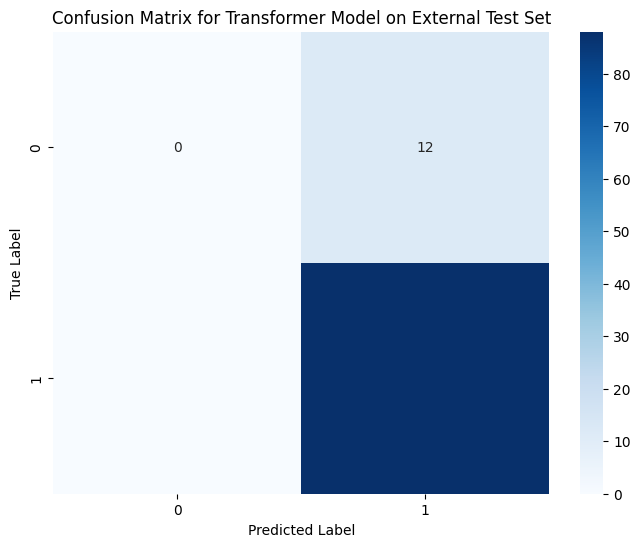

In [ ]:
# Assuming transformer_test_results already contains the predictions and ground truth labels

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check if transformer_test_results contain 'confusion_matrix'
if transformer_test_results and 'confusion_matrix' in transformer_test_results:
    cm = transformer_test_results['confusion_matrix']

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=classifier.label_encoder.classes_ if classifier.label_encoder else range(len(cm)),
                yticklabels=classifier.label_encoder.classes_ if classifier.label_encoder else range(len(cm)))
    plt.title("Confusion Matrix for Transformer Model on External Test Set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
else:
    logger.error("No confusion matrix found in transformer test results.")
